In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.qc import *
from src.utils import write_to_csv 
sns.set_theme(font_scale=1.5)
from tqdm import tqdm
import tikzplotlib
from scipy.optimize import minimize
import pandas as pd

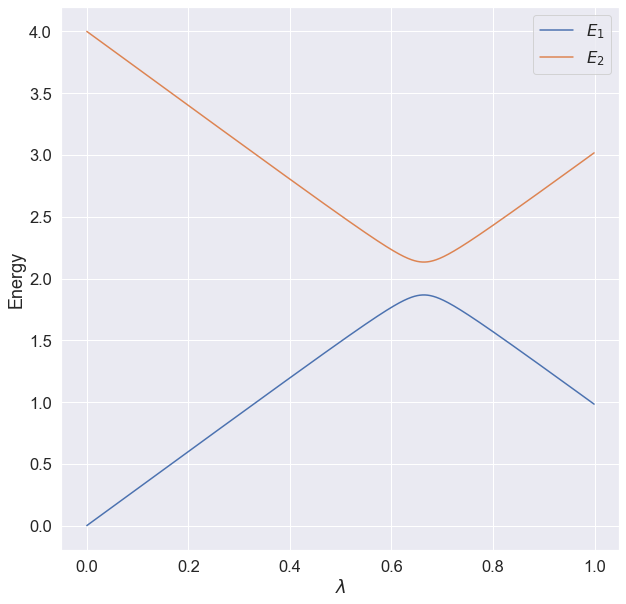

In [2]:
quibit = Qubit(1)
X, Y, Z, I = quibit.X, quibit.Y, quibit.Z, quibit.I
def Hamiltonian(lmb):
    E1 = 0
    E2 = 4
    V11 = 3
    V22 = -3
    V12 = 0.2
    V21 = 0.2

    eps = (E1 + E2) / 2
    omega = (E1 - E2) / 2
    c = (V11 + V22) / 2
    omega_z = (V11 - V22) / 2
    omega_x = V12

    H0 = eps * I + omega * Z
    H1 = c * I + omega_z * Z + omega_x * X
    return H0 + lmb * H1
    
lmbvalues_ana = np.arange(0, 1, 0.001)
eigvals_ana = np.zeros((len(lmbvalues_ana), 2))
for index, lmb in enumerate(lmbvalues_ana):
    H = Hamiltonian(lmb)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for i in range(2):
    axs.plot(lmbvalues_ana, eigvals_ana[:,i], label=f'$E_{i+1}$')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')
axs.legend()
plt.show()


In [3]:
def prepare_state(theta, phi, target = None):
    qubit = Qubit(1)
    I, X, Y = qubit.I, qubit.X, qubit.Y
    state = np.array([1, 0])
    Rx = qubit.Rx(theta)
    Ry = qubit.Ry(phi)
    state = Ry @ Rx @ state
    if target is not None:
        state = target
    return state

In [4]:
def minimize_energy(number_shots, angles_0, learning_rate, max_epochs, unitaries, prepare_state, constants, const_term):
    # angles = np.random.uniform(low = 0, high = np.pi, size = 2)
    angles = angles_0 #lmb*np.array([np.pi, np.pi])
    epoch = 0
    delta_energy = 1
    energy = get_energy(angles=angles, number_shots=number_shots, unitaries=unitaries,
                         prepare_state=prepare_state, constants=constants, const_term=const_term)
    while (epoch < max_epochs) and (delta_energy > 1e-8):
        grad = np.zeros_like(angles)
        for index in range(angles.shape[0]):
            angles_temp = angles.copy()
            angles_temp[index] += np.pi/2 
            E_plus = get_energy(angles=angles_temp, number_shots=number_shots, unitaries=unitaries,
                         prepare_state=prepare_state, constants=constants, const_term=const_term)
            angles_temp[index] -= np.pi 
            E_minus = get_energy(angles=angles_temp, number_shots=number_shots, unitaries=unitaries,
                         prepare_state=prepare_state, constants=constants, const_term=const_term)
            grad[index] = (E_plus - E_minus)/2 
        angles -= learning_rate*grad 
        new_energy = get_energy(angles=angles, number_shots=number_shots, unitaries=unitaries,
                         prepare_state=prepare_state, constants=constants, const_term=const_term)
        delta_energy = np.abs(new_energy - energy)
        energy = new_energy
        epoch += 1
    return angles, epoch, (epoch < max_epochs), energy, delta_energy

In [12]:
qubit = Qubit(1)
unitaries = [qubit.I, qubit.H]

E1 = 0; E2 = 4; V11 = 3; V22 = -3; V12 = 0.2; V21 = 0.2

eps = (E1 + E2) / 2
omega = (E1 - E2) / 2
c = (V11 + V22) / 2
omega_z = (V11 - V22) / 2
omega_x = V12

unitaries = [qubit.I, qubit.H] # for the cirquit measuring Z and X respectively
H0 = eps * I + omega * Z
H1 = c * I + omega_z * Z + omega_x * X


number_shots = 2**(13)
learning_rate = 0.1
max_epochs = 10_000
lmbvalues = np.linspace(0.0, 1.0, 11)
min_energy = np.zeros(len(lmbvalues))
epochs = np.zeros(len(lmbvalues))
for index, lmb in enumerate((lmbvalues)):
    constants = [omega+lmb*omega_z, lmb*omega_x]
    const_term = (eps + lmb*c)
    memory = 0
    np.random.seed(5)
    angles_0 = np.random.uniform(low = -np.pi/2, high = np.pi/2, size = 2)
    angles, epochs[index], converged, energy, delta_energy = minimize_energy(number_shots, angles_0, learning_rate, max_epochs, unitaries, prepare_state, constants, const_term)
    min_energy[index] = energy
    print(converged, epochs[index], min_energy[index], delta_energy, angles)

True 23.0 0.00390625 0.0 [-0.04044964  1.31547114]
True 367.0 0.30001953125 0.0 [-0.00614544  1.32031538]
True 489.0 0.5999707031249999 2.220446049250313e-16 [-0.0273095   1.33076069]
True 527.0 0.898896484375 0.0 [-0.04856341  1.36210908]
True 238.0 1.1983203125000002 0.0 [-0.0923305   1.38656098]
True 616.0 1.49990234375 0.0 [-0.31960125  1.83569331]
True 337.0 1.8120410156250002 0.0 [-1.32127581  2.29712202]
True 4011.0 1.8298876953124998 0.0 [-2.66722723  0.95020258]
True 374.0 1.5698242187499996 0.0 [-2.95292425  0.38072407]
True 3941.0 1.2771142578124999 0.0 [-3.01505413  0.25140571]
True 252.0 0.9806640625 0.0 [-3.043018    0.19587153]


In [15]:
number_shots = 2**(12)
lmbvalues_scipy = np.linspace(0.0, 1.0, 11)
min_energy_scipy = np.zeros(len(lmbvalues_scipy))
for index, lmb in enumerate(tqdm(lmbvalues_scipy)):
    constants = [omega+lmb*omega_z, lmb*omega_x]
    const_term = (eps + lmb*c)
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 2)
    args = (number_shots, unitaries, prepare_state, constants, const_term)
    res = minimize(get_energy, angles_start, args = args, method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    min_energy_scipy[index] = res.fun

100%|██████████| 11/11 [00:01<00:00,  9.94it/s]


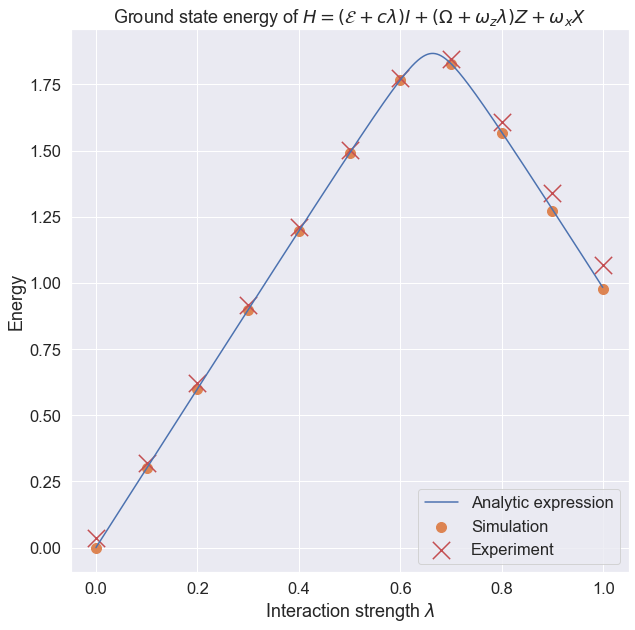

In [18]:
df = pd.read_csv('../data/1D-simple-H.csv')
df_qiskit = pd.read_csv('../data/1D-simple-H_qiskit.csv')
qiskit_lmb = df_qiskit['lmb'].values
qiskit_energies = df_qiskit['energy'].values
lmbvalues = df['lmb'].values
min_energy = df['energy'].values

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
for i in range(1):
    axs.plot(lmbvalues_ana, eigvals_ana[:,i], label=f'Analytic expression', color = '#4c72b0')
axs.scatter(lmbvalues, min_energy, label = 'Simulation', color = '#dd8452', marker = 'o', s = 100)
axs.scatter(qiskit_lmb, qiskit_energies, label = 'Experiment', color = '#c44e52', marker = 'x', s = 300)
axs.set_xlabel(r'Interaction strength $\lambda$')
axs.set_ylabel('Energy')
axs.set_title(r'Ground state energy of $H = (\mathcal{E}+ c\lambda)I + (\Omega + \omega_z\lambda) Z + \omega_x X$')
plt.legend(loc = 'lower right')
tikzplotlib.clean_figure()
tikzplotlib.save(
    f'../plots/1D-simple-H.tex',
    extra_axis_parameters=[
        'title style={align=center}',
        'xmajorticks=true',
        'ymajorticks=true',
        'mark options={mark size=1.4pt, line width=1.5pt}',
        ],
        strict=True,
    )
plt.show()

